In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import time

C:\Users\HP\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv('GOOGL.csv')

In [3]:
data_copy = data.copy()

data_copy.dropna(inplace=True)

selected_features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
data_copy = data_copy[selected_features]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_copy)

In [4]:
df = pd.DataFrame(data)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


In [5]:
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [6]:
print("Dataset shape:", df.shape)
print("Columns:", df.columns)
print("Info:\n", df.info())
print("Summary statistics:\n", df.describe())

Dataset shape: (4431, 7)
Columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4431 entries, 0 to 4430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4431 non-null   object 
 1   Open       4431 non-null   float64
 2   High       4431 non-null   float64
 3   Low        4431 non-null   float64
 4   Close      4431 non-null   float64
 5   Adj Close  4431 non-null   float64
 6   Volume     4431 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 242.4+ KB
Info:
 None
Summary statistics:
               Open         High          Low        Close    Adj Close  \
count  4431.000000  4431.000000  4431.000000  4431.000000  4431.000000   
mean    693.087345   699.735595   686.078751   693.097367   693.097367   
std     645.118799   651.331215   638.579488   645.187806   645.187806   
min      49.644646  

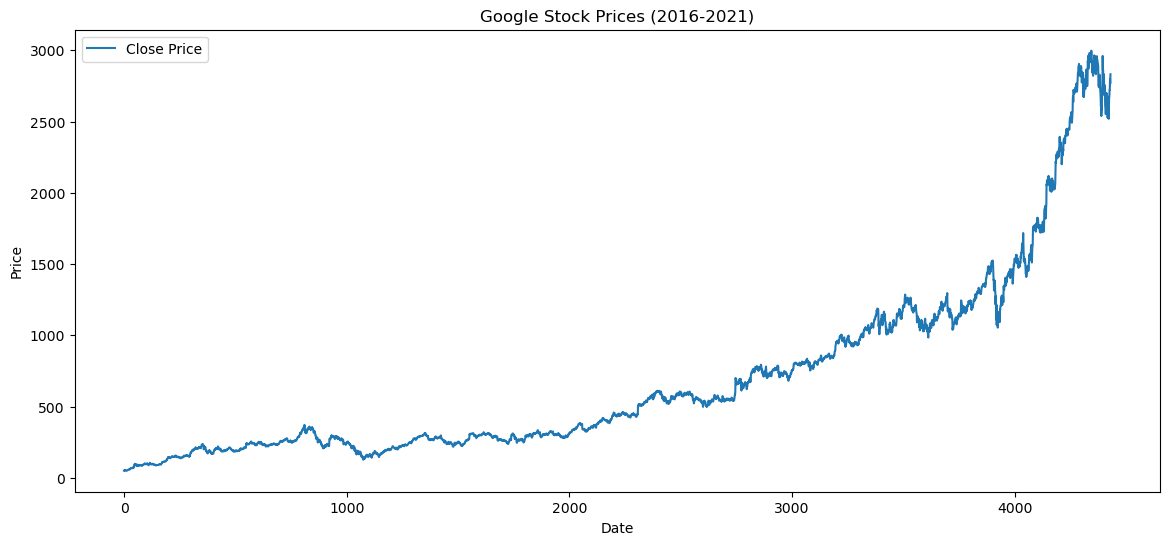

In [7]:
plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='Close Price')
plt.title('Google Stock Prices (2016-2021)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [8]:
df['Date'] = pd.to_datetime(df['Date'], utc=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19 00:00:00+00:00,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20 00:00:00+00:00,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23 00:00:00+00:00,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24 00:00:00+00:00,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25 00:00:00+00:00,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


In [9]:
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 60  

X, y = prepare_data(scaled_data, time_steps)

In [10]:
split_ratio = 0.8  # Train-test split ratio
split_index = int(split_ratio * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [11]:
model = Sequential([
    LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=100, return_sequences=True),
    Dropout(0.2),
    LSTM(units=100),
    Dropout(0.2),
    Dense(units=len(selected_features))
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

# Display model
print(model.summary())

C:\Users\HP\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 100)             │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             606 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 204,206 (797.68 KB)

 Trainable params: 204,206 (797.68 KB)

 Non-trainable params: 0 (0.00 B)

None


In [12]:
# Measure training time
start_time = time.time()

epochs = 50 
history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1)

training_time = time.time() - start_time
print("Training Time:", training_time, "seconds")

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.3852 - loss: 0.0041
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.4430 - loss: 0.0010
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.4623 - loss: 8.9095e-04
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.4469 - loss: 0.0010
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.4870 - loss: 8.6484e-04
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.4840 - loss: 7.5592e-04
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.4714 - loss: 7.8450e-04
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.4870 - loss: 7.2572e-04
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.4774 - loss: 7.0215e-04
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.4815 - loss: 6.6386e-04
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.4591 - loss: 6.2397e-04
Epoch 

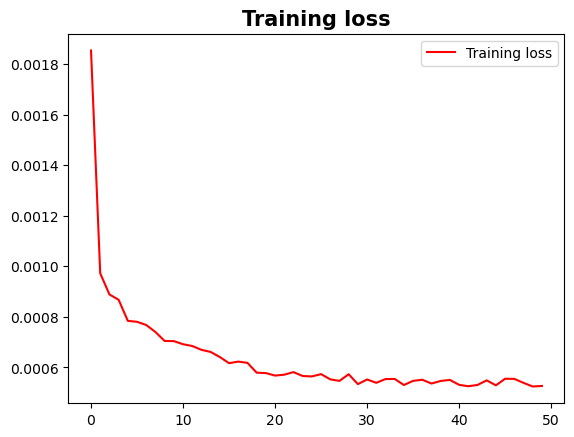

<Figure size 640x480 with 0 Axes>

Train Loss: [0.0004432935966178775, 0.665617823600769]
Test Loss: [0.004664221778512001, 0.47200000286102295]


In [13]:
loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')

plt.title('Training loss', size=15, weight='bold')
plt.legend(loc=0)
plt.figure()

plt.show()
#model evaluasi
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print(f"Train Loss: {train_loss}")
print(f"Test Loss: {test_loss}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
Prediction Time: 1.9890620708465576 seconds


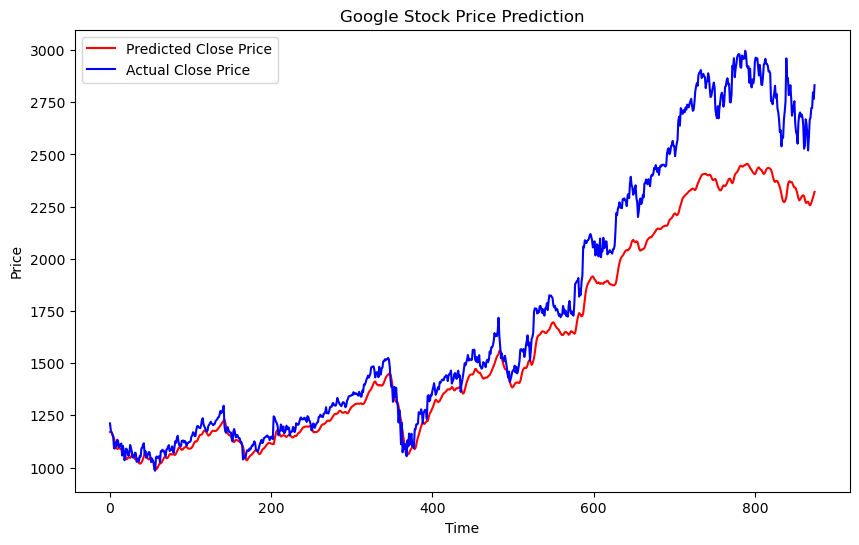

In [14]:
# Measure prediction time
start_time = time.time()

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test)

prediction_time = time.time() - start_time
print("Prediction Time:", prediction_time, "seconds")

# predicted vs actual
plt.figure(figsize=(10, 6))
plt.plot(predictions[:,3], label='Predicted Close Price', color='r')
plt.plot(y_test_inverse[:,3], label='Actual Close Price', color='b')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()